In [1]:
import sys
import logging
import os
import math
import json
from tqdm import tqdm
import warnings
from IPython.display import display, Audio

import numpy as np
import librosa

import torch

import scdata

sys.path.append('..')
logging.getLogger().setLevel(logging.INFO)
warnings.filterwarnings('ignore')

from aural_travels.data import soundcloud
from aural_travels.train import visualizer

MODEL_DIR = '/home/leo/src/aural-travels/models/nat_vqgan_zoom_pairs'
DATA_DIR = '/home/leo/src/scdata'

In [2]:
with open(os.path.join(MODEL_DIR, 'params.json')) as f:
    params = json.load(f)
    
params

{'soundcloud_data_dir': '/home/leo/src/scdata',
 'dataset': 'soundcloud',
 'num_workers': 64,
 'batch_size': 64,
 'gradient_accumulation': 2,
 'num_epochs': 1000,
 'hidden_size': 512,
 'num_layers': 16,
 'num_heads': 8,
 'attention_dropout': 0.0,
 'ffnn_dropout': 0.0,
 'lr': 0.001,
 'output_dir': 'models/nat_vqgan_zoom_pairs',
 'sample_secs': 2.0,
 'n_fft': 2048,
 'hop_length': 1024,
 'save_steps': 100,
 'eval_steps': 100,
 'non_autoregressive': True,
 'corrupt_image_mode': None,
 'seed': 42,
 'toy_data': False,
 'expose_steps': None,
 'expose_alpha': 0.5,
 'axial_attention': False,
 'image_repr': 'vqgan'}

In [3]:
#split = 'training'
split = 'validation'
device = 'cpu'

image_repr = visualizer.create_image_repr(params).to(device)
dataset = visualizer.load_dataset(params, image_repr, split)
model = visualizer.create_model(params, image_repr, dataset).to(device)

checkpoint = torch.load(os.path.join(MODEL_DIR, 'last_checkpoint.pt'))
model.load_state_dict(checkpoint['model'])

checkpoint['global_step']

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


500

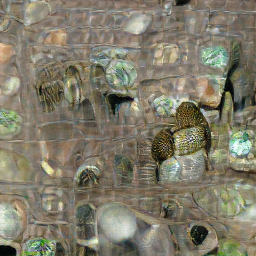

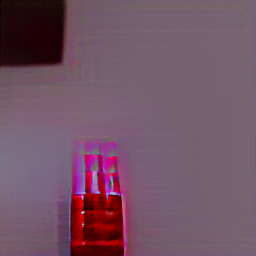

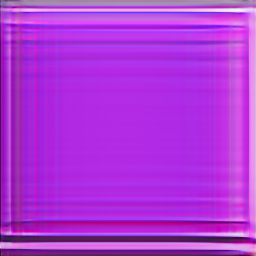

In [4]:
def show(image_seq, save=None):
    image = image_repr.tensor_to_image(image_repr.decode(image_seq)[0])
    display(image)
    if save:
        image.save(save)
    return image

corrupt_image_seq = image_repr.rand_image_seq(1, device=device)
show(corrupt_image_seq)

corrupt_image_seq = image_repr.rand_image_seq(1, device=device, patch_size=4)
show(corrupt_image_seq)

corrupt_image_seq = image_repr.zeros_image_seq(1, device=device)
show(corrupt_image_seq)
1
print('')

lofi: Storybook (877111480)
input_image_seq


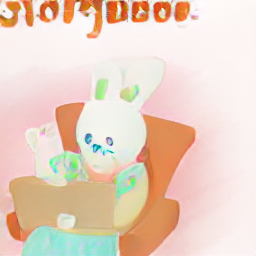

control
tensor([[ 0, -9, 12]])
target_image_seq


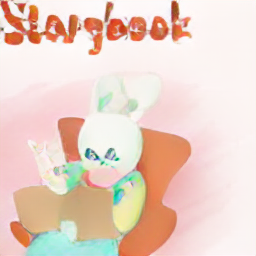

generated


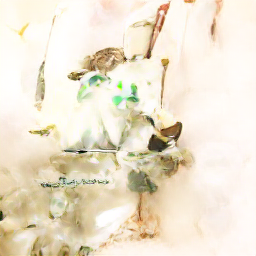

Electronic: Between The Rings (334831124)
input_image_seq


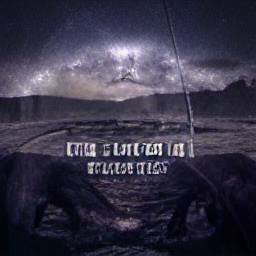

control
tensor([[-1,  0,  0]])
target_image_seq


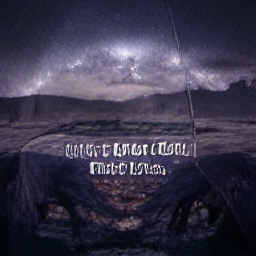

generated


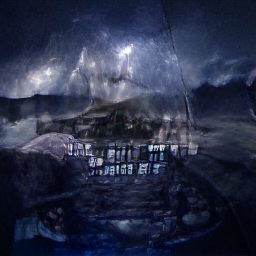

Dance & EDM: Gryffin & Illenium - Feel Good (Thomas Gresen Remix) Ft Daya (334794044)
input_image_seq


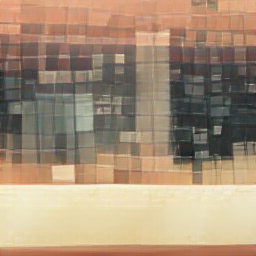

control
tensor([[ 8,  5, 14]])
target_image_seq


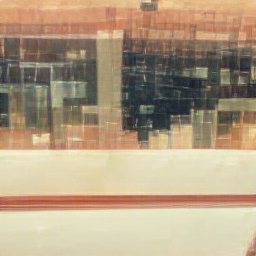

generated


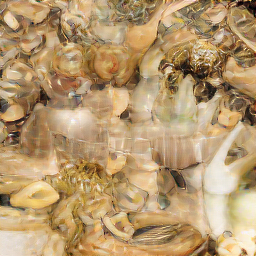

In [7]:
indices = list(range(3))

for idx in indices:
    track = dataset.tracks[idx]
    print(f'{track["genre"]}: {track["title"]} ({track["id"]})')
    
    item = dataset[idx]
    batch = {
        'audio_seq': item['audio_seq'][None, ...].to(device),
        'input_image_seq': image_repr.encode(item['input_image'][None, ...].to(device)),
        'target_image_seq': image_repr.encode(item['target_image'][None, ...].to(device)),
        'control': item['control'][None, ...].to(device)
    }
    
    print('input_image_seq')
    show(batch['input_image_seq'])
    
    print('control')
    print(batch['control'])
    
    print('target_image_seq')
    show(batch['target_image_seq'])
    
    print('generated')
    image_seq = model.generate_image_seq(batch['audio_seq'],
                                         batch['control'],
                                         batch['input_image_seq'],
                                         temperature=1,
                                         top_k=0)
    show(image_seq)